In [24]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [35]:
# defining some functions for latter


#defining function the determine our Ax and than pad it so we dont get bugs

def Ax(V,mask):
    Vuse=V.copy()
    Vuse[mask]=0
    ans=(Vuse[1:-1,:-2]+Vuse[1:-1,2:]+Vuse[2:,1:-1]+Vuse[:-2,1:-1])/4.0
    ans=ans-V[1:-1,1:-1]
    return ans

def pad(A):
    AA=np.zeros([A.shape[0]+2,A.shape[1]+2])
    AA[1:-1,1:-1]=A
    return AA

def cylinder(n,R):
    bc = np.zeros([n,n])
    mask = np.zeros([n,n])
    a = np.arange(n)
    i, j = np.meshgrid(a, a,indexing = 'ij')
    mask = (i-n//2)**2 +(j-n//2)**2 < R**2
    bc[mask]=1.0
    mask[:,0]=True
    mask[:,-1]=True
    mask[0,:]=True
    mask[-1,:]=True
    return mask, bc


1

In [26]:
#setting up the intial conditions with every cpnstant set to 1 and voltage on the cylinder being one
n=400
V=np.zeros([n,n])
R=0.2*n
mask, bc= cylinder(n,R)
tol=10**(-2)

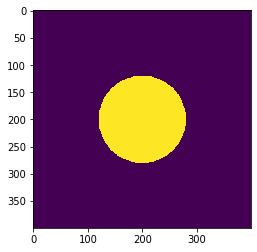

In [27]:
plt.imshow(bc)

In [28]:
t1=time.time()
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
for i in range(100000):
    V[1:-1,1:-1]=(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0
    V[mask]=bc[mask]
    r=b-Ax(V,mask)
    rtr=np.sum(r*r) #adding residuals so we can check convergence 
    if rtr<tol:
        break
        print("convereged on iteration",i)
print('it took',time.time()-t1,'s to reach the treshold ')

it took 20.486062049865723 s to reach the treshold 


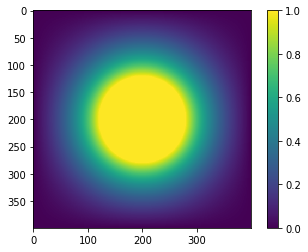

In [29]:
plt.clf()
plt.imshow(V)
plt.colorbar()

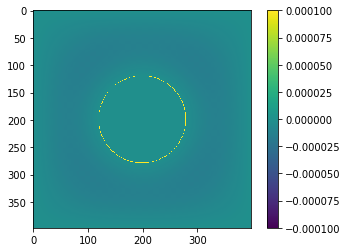

In [30]:
#ploting charge to show its only at the boundry of the cylinder 
plt.clf()
rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0
plt.imshow(rho)
plt.colorbar()
plt.clim(vmin=-.1**4,vmax=.1**4)

In [31]:
rho=pad(rho)
a = np.arange(n)
i, j = np.meshgrid(a, a,indexing = 'ij')
over =(i-n//2)**2 +(j-n//2)**2< (R+1)**2
under=(R-1)**2<((i-n//2)**2 +(j-n//2)**2)
edge= over&under
lam=sum(rho[edge])/(2*np.pi*R)
print('the charge density is', lam)

the charge density is 0.003920982944377796


We see the voltage decaying as we go away from the clyinder as expected. Furthermore the boundry of the conductors contains all the charge (mostly) we see some error on a scale of $10^{-4}$ when we set the tolerance to $10^{-2}$

2

In [37]:
#setting up the intial conditions with every cpnstant set to 1 and voltage on the cylinder being one
n=400
V=np.zeros([n,n])
mask, bc= cylinder(n,R)

In [38]:
#defining variables for our conjugate gradient 
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
p=r.copy()


In [39]:
t1=time.time()
for k in range(1000):
    Ap=(Ax(pad(p),mask))
    rtr=np.sum(r*r)
    if rtr<tol:
        break
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew
print('it took',time.time()-t1,'s')
rho=V[1:-1,1:-1]-(V[1:-1,0:-2]+V[1:-1,2:]+V[:-2,1:-1]+V[2:,1:-1])/4.0

it took 0.18387508392333984 s


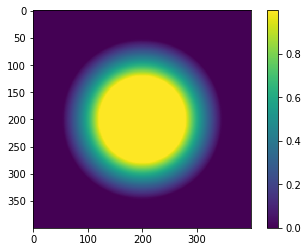

In [40]:
plt.clf()
plt.imshow(V)
plt.colorbar()
plt.show()

To get to the same threshold with this method takes of order 100 times less

3 

In [44]:
#setting up the intial conditions with every constant set to 1 and voltage on the cylinder being one
n=100
V=np.zeros([n,n])
tol=10**(-10)
mask, bc= cylinder(n,0.2*n)


#defining variables for our conjugate gradient 
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
p=r.copy()


t1=time.time()
for k in range(5000):
    Ap=(Ax(pad(p),mask))
    rtr=np.sum(r*r)
    if rtr<tol:
        break
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew

    
#itteravly making the grid finner we will do this 4 times
Nfine_step=4
for z in range(Nfine_step):
    n=n*2
    Vold=V.copy()
    V=np.zeros([n,n])
    mask, bc= cylinder(n,0.2*n)
    
    for i in range(n//2):
        for j in range(n//2):
            V[i*2:i*2+2,j*2:j*2+2]=Vold[i,j] 
    # redoing conj grad
    
    b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
    r=b-Ax(V,mask)
    p=r.copy()
    for k in range(5000):
        Ap=(Ax(pad(p),mask))
        rtr=np.sum(r*r)    
        if rtr<tol:
            break
        alpha=rtr/np.sum(Ap*p)
        V=V+pad(alpha*p)
        rnew=r-alpha*Ap
        beta=np.sum(rnew*rnew)/rtr
        p=rnew+beta*p
        r=rnew
    
    
print('it took',time.time()-t1,'s')



it took 92.06831383705139 s


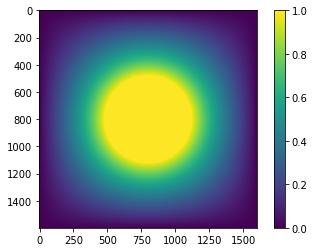

In [45]:
plt.clf()
plt.imshow(V)
plt.colorbar()
plt.show()

We get about 100 seconds to get bellow a reasonable tolerance of $10^{-10}$ now to compare it by just starting with a 1600x1600

In [46]:
#we will be starting with 1600 and runing to the same tolerance

n=1600
V=np.zeros([n,n])
mask, bc= mask, bc= cylinder(n,0.2*n)

b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
p=r.copy()
t1=time.time()
for k in range(10000):
    Ap=(Ax(pad(p),mask))
    rtr=np.sum(r*r)
    if rtr<tol:
        break
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew
    
print('it took',time.time()-t1,'s')


it took 138.59755301475525 s


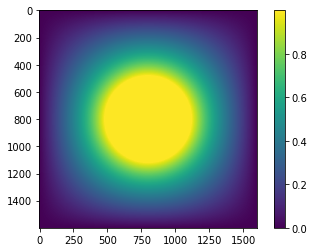

In [47]:
plt.clf()
plt.imshow(V)
plt.colorbar()
plt.show()

Doing it with intialy 1600x1600 increases the compuation time by about 50% for us, a sginificant enough time that its worth iterativly increasing size


4

In [48]:
#setting up the intial conditions with every cpnstant set to 1 and voltage on the cylinder with a bump in it
n=100
V=np.zeros([n,n])
R=0.2*n
bc = np.zeros([n,n])
a = np.arange(n)
i, j = np.meshgrid(a, a,indexing = 'ij')
mask = (i-n//2)**2 +(j-n//2)**2 < R**2
mask[15*n//32:(17*n//32),6*n//10:3*n//4]=True
bc[mask]=1.0
mask[:,0]=True
mask[:,-1]=True
mask[0,:]=True
mask[-1,:]=True



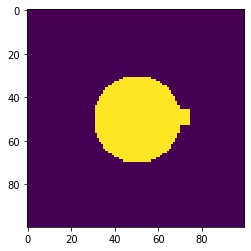

In [49]:
plt.imshow(bc)

In [13]:
#defining variables for our conjugate gradient 
b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
r=b-Ax(V,mask)
p=r.copy()


t1=time.time()
for k in range(5000):
    Ap=(Ax(pad(p),mask))
    rtr=np.sum(r*r)
    if rtr<tol:
        break
    alpha=rtr/np.sum(Ap*p)
    V=V+pad(alpha*p)
    rnew=r-alpha*Ap
    beta=np.sum(rnew*rnew)/rtr
    p=rnew+beta*p
    r=rnew

    
#itteravly making the grid finner we will do this 4 times
Nfine_step=4
for z in range(Nfine_step):
    n=n*2
    Vold=V.copy()
    V=np.zeros([n,n])
    #redefining the mask
    R=0.2*n
    bc = np.zeros([n,n])
    a = np.arange(n)
    i, j = np.meshgrid(a, a,indexing = 'ij')
    mask = (i-n//2)**2 +(j-n//2)**2 < R**2
    mask[15*n//32:(17*n//32),6*n//10:3*n//4]=True
    bc[mask]=1.0
    mask[:,0]=True
    mask[:,-1]=True
    mask[0,:]=True
    mask[-1,:]=True
    
    for i in range(n//2):
        for j in range(n//2):
            V[i*2:i*2+2,j*2:j*2+2]=Vold[i,j] 
    # redoing conj grad
    
    b=-(bc[1:-1,0:-2]+bc[1:-1,2:]+bc[:-2,1:-1]+bc[2:,1:-1])/4.0
    r=b-Ax(V,mask)
    p=r.copy()
    for k in range(5000):
        Ap=(Ax(pad(p),mask))
        rtr=np.sum(r*r)
        if rtr<tol:
            break
        alpha=rtr/np.sum(Ap*p)
        V=V+pad(alpha*p)
        rnew=r-alpha*Ap
        beta=np.sum(rnew*rnew)/rtr
        p=rnew+beta*p
        r=rnew
    
    
print('it took',time.time()-t1,'s')

it took 87.7023491859436 s


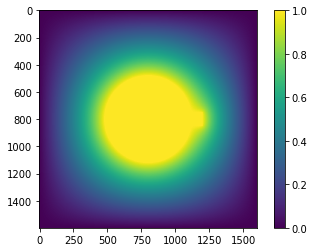

In [14]:
plt.clf()
plt.imshow(V)
plt.colorbar()
plt.show()

In [24]:
E=np.gradient(V)
E2=np.square(E)
E_norm=np.sqrt(E2[0]+E2[1])

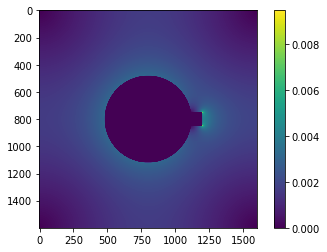

In [29]:
plt.clf()
plt.imshow(E_norm)
plt.colorbar()
plt.show()

We see that along the axis of the bump the field is much larger than all other areas of the wire which would waste alot of energy if this was a wire transporting elctricty. 

5

the heat equation is $u_t=D\nabla^2 u$

you can not that this is just laplaces equation with time dependent boundry conditions.

the diffusion coeffients coressopnds to the number of relaxation steps you do before you do a time step we will be looking at 2 regims fast and slow diffusion not paying close attention to the numerical value of D 

In [50]:
t_o=np.linspace(0,10,50)
n=100
i=0
u=np.zeros([n,n])
bc=np.zeros([n,n])
mask=np.zeros([n,n],dtype='bool')
mask[:,0]=True
mask[:,-1]=True
mask[0,:]=True
mask[-1,:]=True
bc[:,0]=0

Note that the following is a heat map that changes in time 

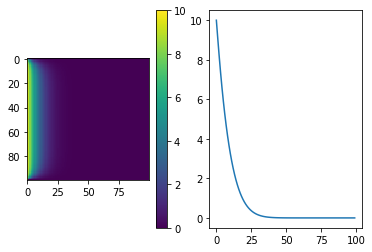

In [51]:
from IPython.display import display, clear_output
#low diffusion regime
for t in t_o:
    bc[:,0]=t
    for i in range(10):
        u[1:-1,1:-1]=(u[1:-1,0:-2]+u[1:-1,2:]+u[:-2,1:-1]+u[2:,1:-1])/4.0
        u[mask]=bc[mask]
    plt.subplot(1, 2, 1)
    plt.imshow(u)
    plt.colorbar()
    plt.clim(vmin=0,vmax=10)
    clear_output(wait = True)
    plt.subplot(1, 2, 2)
    plt.plot(u[n//2,:])
    plt.pause(0.0001)
    plt.close()

We see that all the change is localized to the left edge for the most part and that the right edge is beyond the domain of influence.  In fact we see almost a layered response with each time step

In [54]:
t_o=np.linspace(0,10,50)
n=100
i=0
u=np.zeros([n,n])
bc=np.zeros([n,n])
mask=np.zeros([n,n],dtype='bool')
mask[:,0]=True
mask[:,-1]=True
mask[0,:]=True
mask[-1,:]=True
bc[:,0]=0

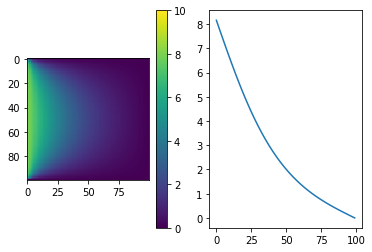

In [ ]:
from IPython.display import display, clear_output
#high diffusion regime
for t in t_o:
    bc[:,0]=t
    for i in range(100000):
        u[1:-1,1:-1]=(u[1:-1,0:-2]+u[1:-1,2:]+u[:-2,1:-1]+u[2:,1:-1])/4.0
        u[mask]=bc[mask]
    plt.subplot(1, 2, 1)
    plt.imshow(u)
    plt.colorbar()
    plt.clim(vmin=0,vmax=10)
    clear_output(wait = True)
    plt.subplot(1, 2, 2)
    plt.plot(u[n//2,:])
    plt.pause(0.0001)
    plt.close()

We see here a more global effect though the chage in the heat plot


When we compare the plots this becomes more apparent as in low diffusion regieme we actually see the limits on the domain of influence but in the high diffusion plot we can see the square root natue of heat diffusion